In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_csv('h2a.csv')
df.head()
df = df.loc[824:39000]

In [3]:
def convert_time_to_seconds(df, time_column):
    # Convert the time column to datetime format
    df[time_column] = pd.to_datetime(df[time_column], format='%m/%d/%Y %H:%M:%S.%f')

    # Calculate the time difference in seconds
    df['Time'] = (df[time_column] - df[time_column].min()).dt.total_seconds()

    return df

[ 23.13923163 -31.00751685]


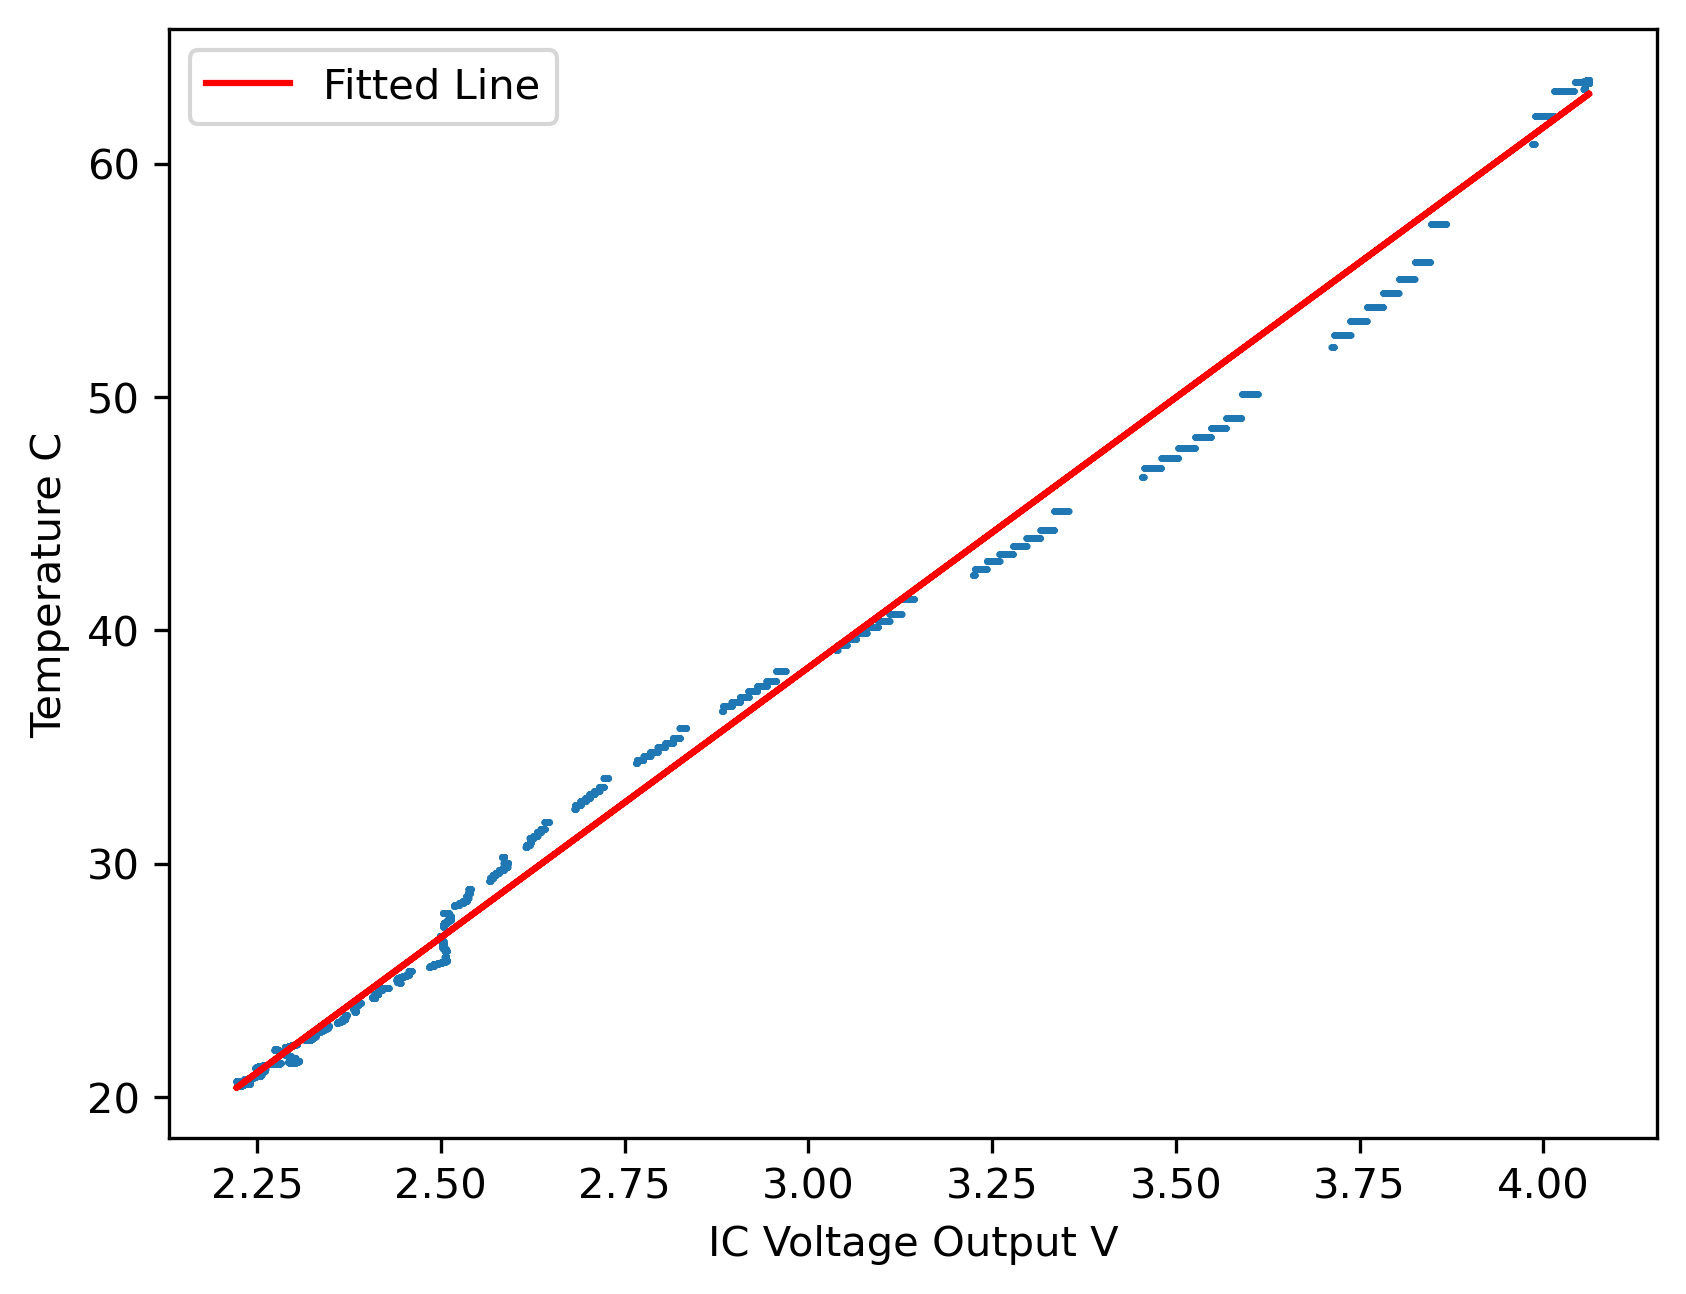

In [4]:
# get coefficents for calibrating IC Temperature Sensor
selected_rows = convert_time_to_seconds(df, 'Time')
plt.scatter(
    selected_rows['Voltage_1 (Collected)'],
    selected_rows['Temperature_0 (Collected)'], 
    marker='.',
    s = 1)

coefficients = np.polyfit(selected_rows['Voltage_1 (Collected)'], selected_rows['Temperature_0 (Collected)'], 1)

# Create a line using the fitted coefficients
line = np.polyval(coefficients, selected_rows['Voltage_1 (Collected)'])

# Plot the fitted line
plt.plot(selected_rows['Voltage_1 (Collected)'], line, color='red', label='Fitted Line')

plt.xlabel('IC Voltage Output V')
plt.ylabel('Temperature C')
plt.legend()


print(coefficients)

# calculate temperature from coefficents
df['Temperature_2 (IC Sensor)'] = coefficients[0]*df['Voltage_1 (Collected)'] + coefficients[1]

Coefficient A: 0.026222200284926736
Coefficient B: -0.0821269646089058
Coefficient C: 0.0954699777750244


Text(0, 0.5, 'Temperature')

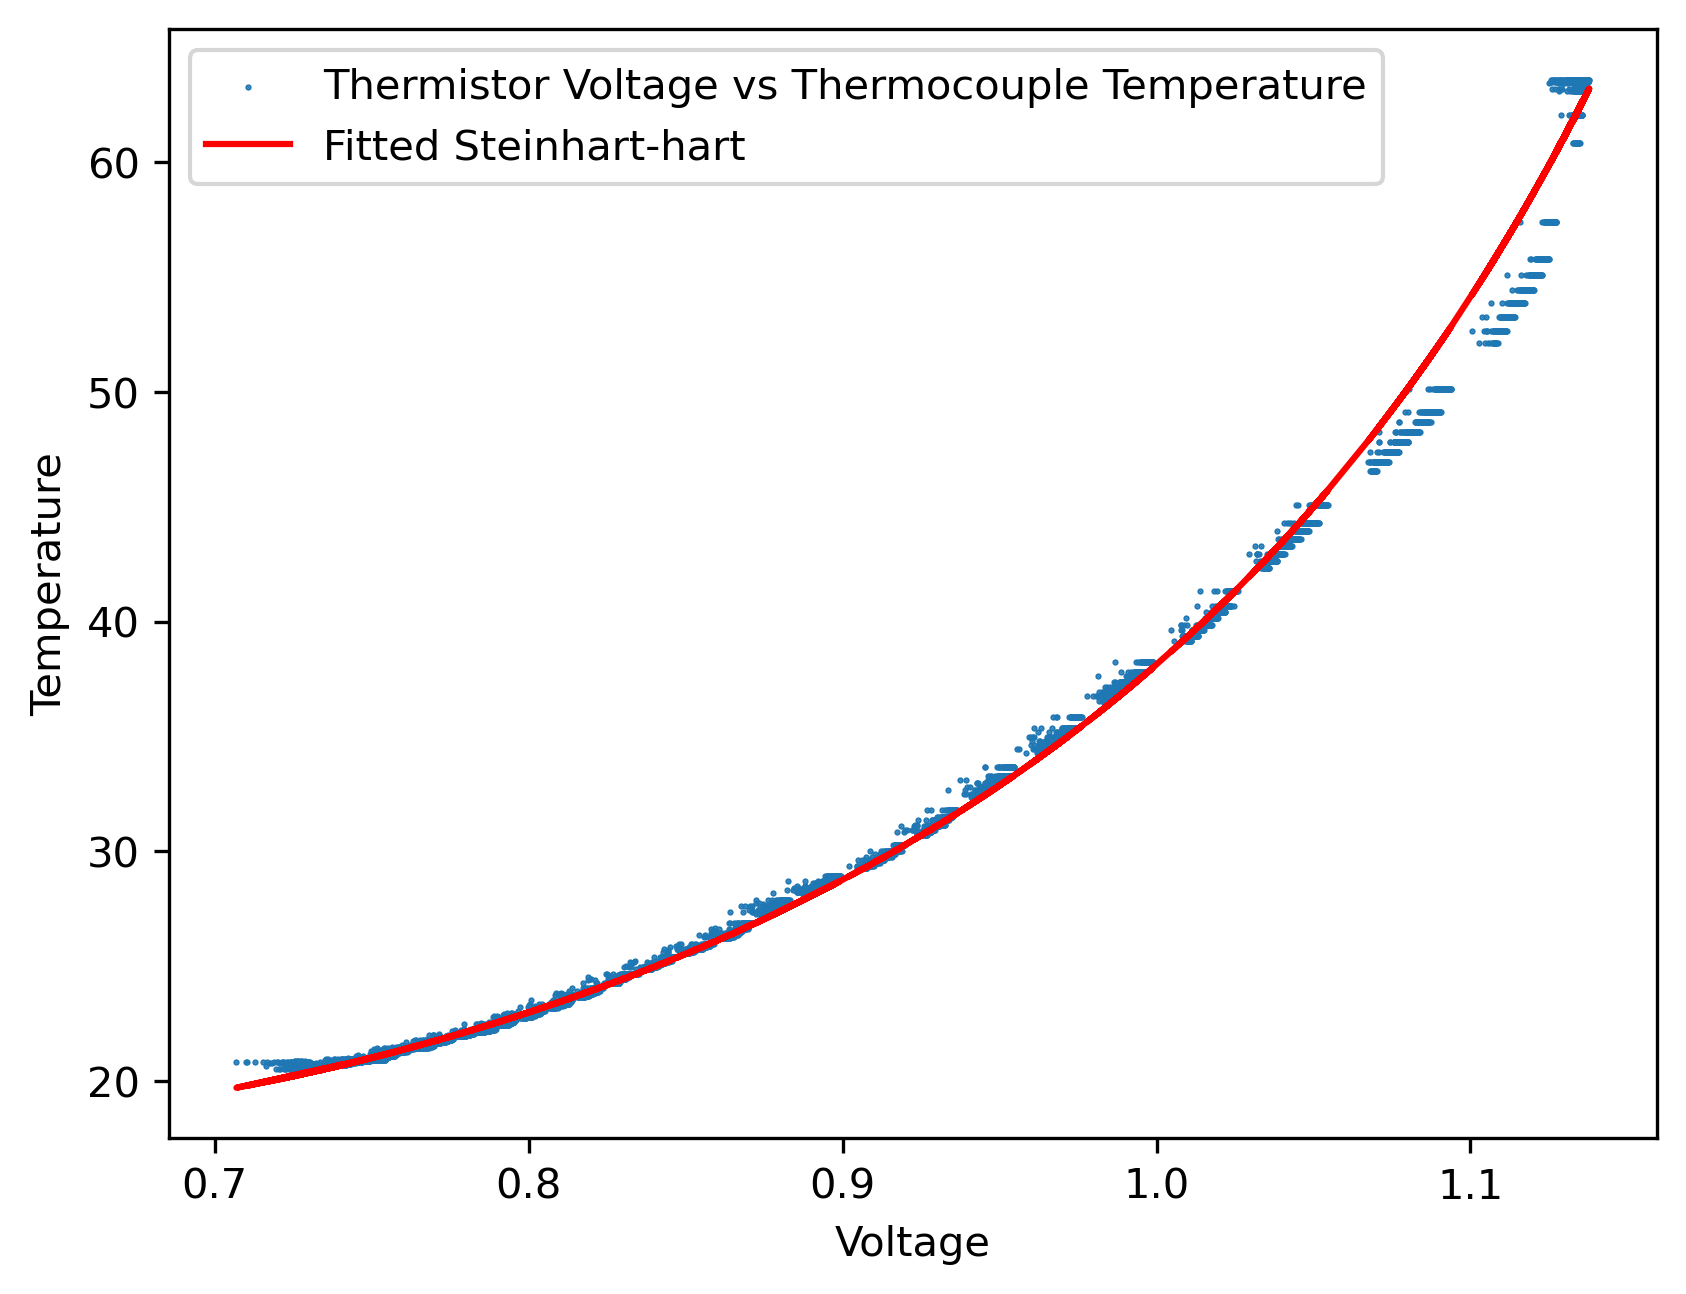

In [5]:


# Define the Steinhart-Hart equation
def steinhart_hart_equation(resistance, A, B, C):
    return  (A + B * np.log(resistance) + C * (np.log(resistance))**3)

# Fit the equation to the data
initial_guess = [1, 1, 1]  # You may need to adjust these initial values based on your data
coefficients, covariance = curve_fit(steinhart_hart_equation, df['Voltage_0 (Collected)'], 1 / df['Temperature_0 (Collected)'], p0=initial_guess)

# Coefficients
A, B, C = coefficients
print(f"Coefficient A: {A}")
print(f"Coefficient B: {B}")
print(f"Coefficient C: {C}")

# calculate temperature

def calculate_temperature(voltage):
    temperature = 1 / (A + B * np.log(voltage) + C * (np.log(voltage))**3)
    return temperature

df['Temperature_1 (Thermistor)'] = df['Voltage_0 (Collected)'].apply(calculate_temperature)

plt.scatter(df['Voltage_0 (Collected)'], 
            df['Temperature_0 (Collected)'], 
            marker = '.', 
            s = 1, 
            label = 'Thermistor Voltage vs Thermocouple Temperature')

plt.plot(df['Voltage_0 (Collected)'], 
         df['Temperature_1 (Thermistor)'], 
         color = 'red',
         label = 'Fitted Steinhart-hart')

plt.legend()
plt.xlabel('Voltage')
plt.ylabel('Temperature')

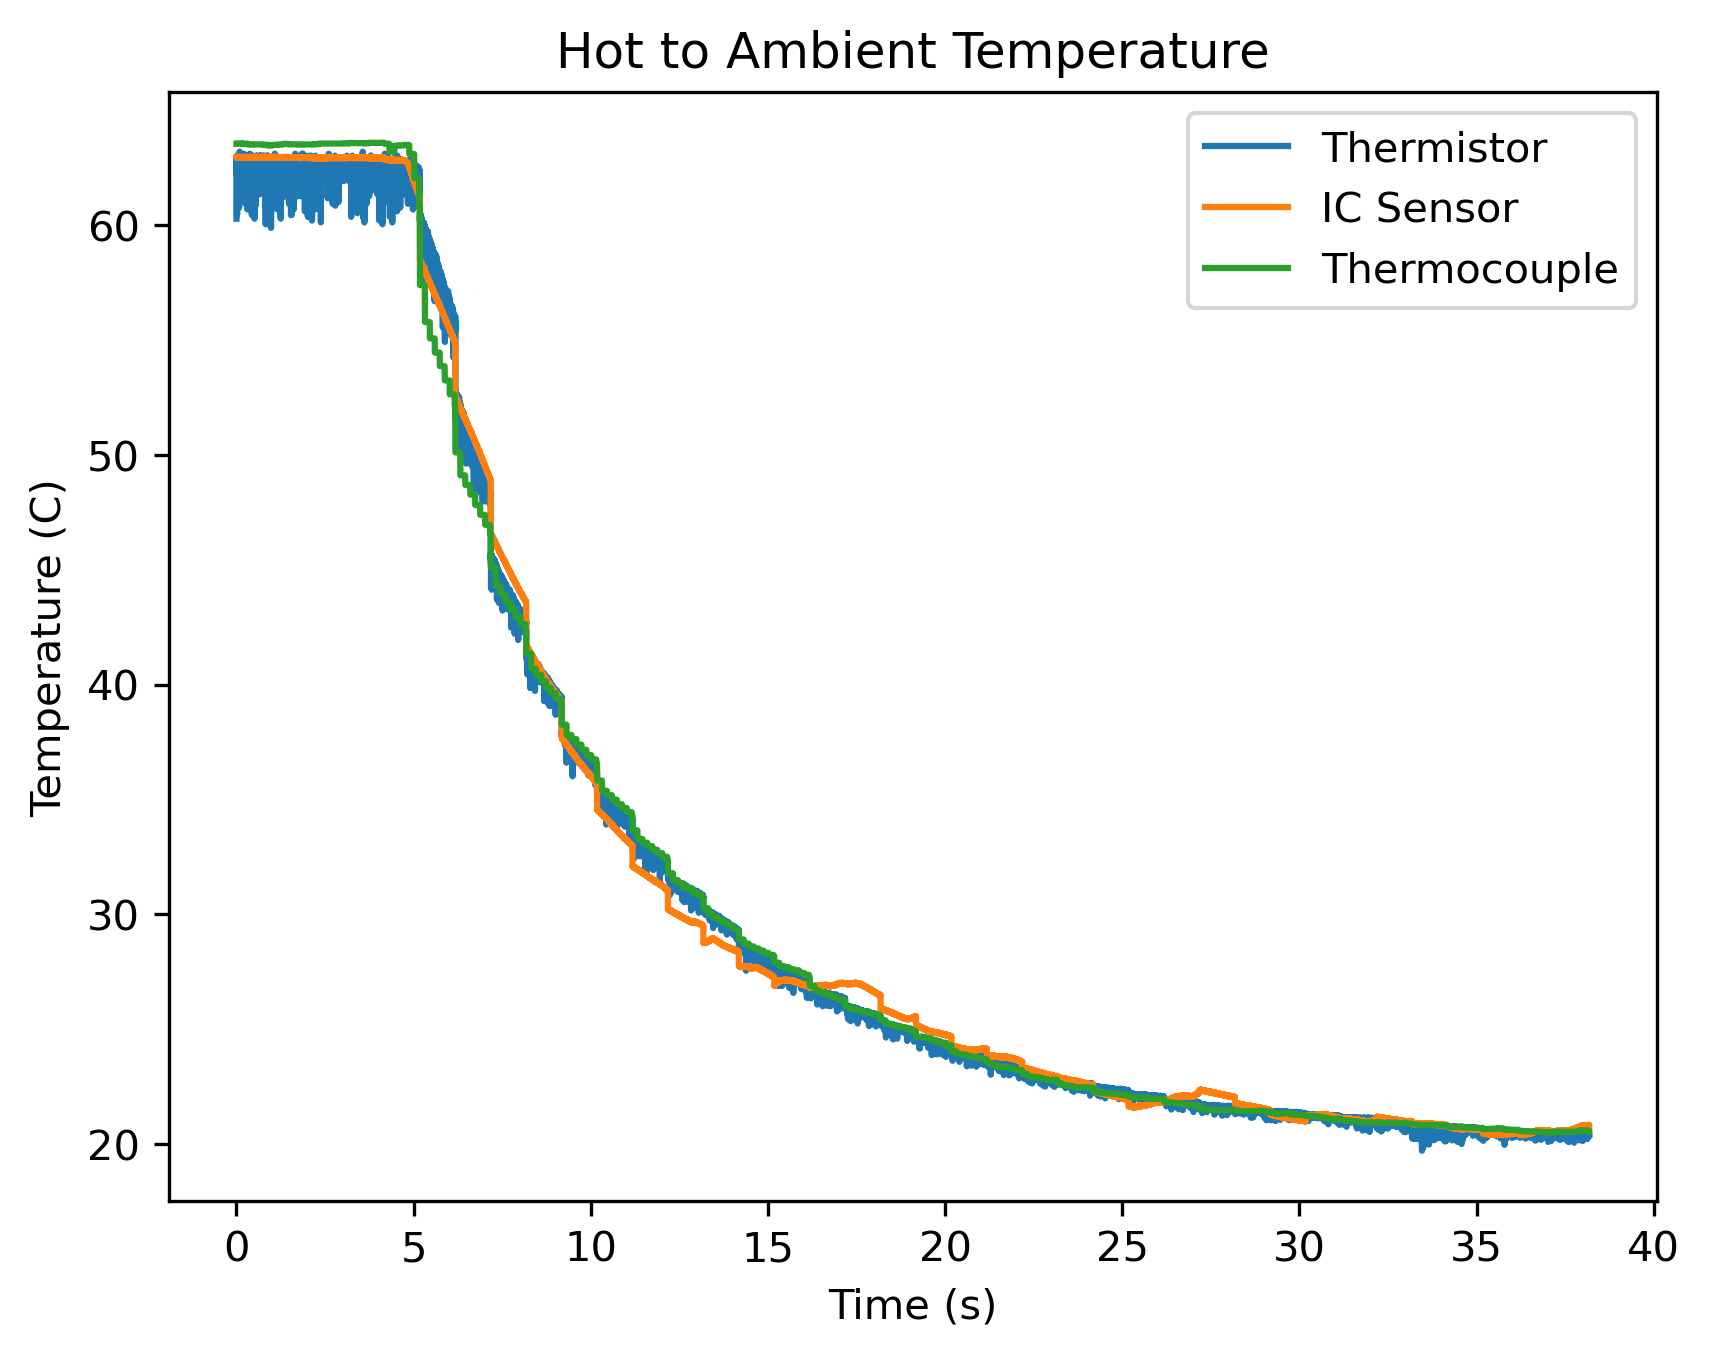

In [6]:
# Calculate Temperature from IC voltage


plt.plot(df['Time'],df['Temperature_1 (Thermistor)'], label = 'Thermistor', alpha = 1.0)
plt.plot(df['Time'],df['Temperature_2 (IC Sensor)'], label = 'IC Sensor', alpha = 1.0)
plt.plot(df['Time'], df['Temperature_0 (Collected)'], label = 'Thermocouple', alpha = 1.0)


plt.title('Hot to Ambient Temperature')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')

plt.show()